In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

2450083.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

01
02
03
04
05
06
07
08
09
10
11
12


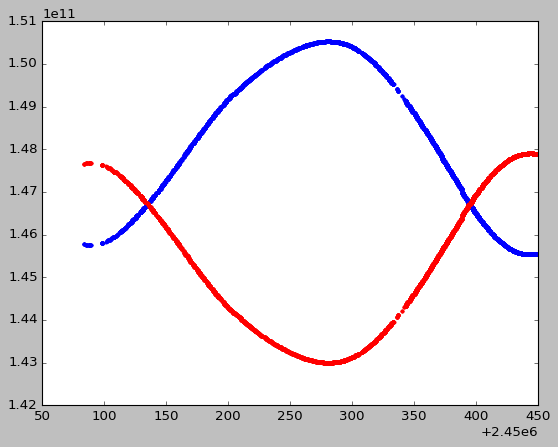

In [25]:
#for year in range(1996, 2010):
for year in [1996]:
    solarDistances = []
    obsDates = []
    solarRads = []
    pixelScales = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                
                solarDistances.append(header['DSUN_OBS'])
                obsDates.append(header['DATE-BEG'])
                solarRads.append(header['RSUN_OBS'])
                pixelScales.append(header['CDELT1'])
                
    solarDistances = np.array(solarDistances)
    solarRads = np.array(solarRads)
    pixelScales = np.array(pixelScales)
    t = astropy.time.Time(obsDates, format='isot', scale='utc').jd
    plt.plot(t[solarDistances>1.e11], solarDistances[solarDistances>1.e11],'b.')
    plt.plot(t[solarDistances>1.e11], solarRads[solarDistances>1.e11]*1.5e8,'r.')
    #plt.plot(t[solarDistances>1.e11], pixelScales[solarDistances>1.e11],'k.')
    
    

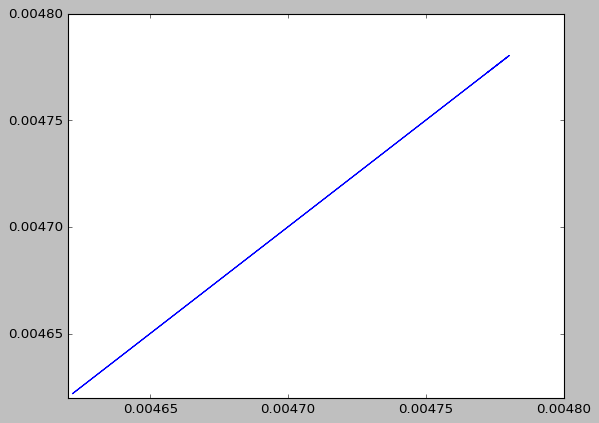

In [26]:
plt.plot(solarRads[solarDistances>1.e11] * np.pi/(3600*180.), 695699968/solarDistances[solarDistances>1.e11])

In [21]:
medianSolarDistance = np.median(solarDistances[solarDistances > 0.])
print(medianSolarDistance)
minSolarDistance = np.min(solarDistances[solarDistances > 0.])
print(minSolarDistance)

maxSolarRad = np.max(solarRads[solarDistances > 0.])
print(maxSolarRad)

147502379932.0
145533274325.0
986.010427668


In [28]:
print(np.round(4.5352,0))

5.0


01
02
03
04
05
06
07
08
09
10
11
12


/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


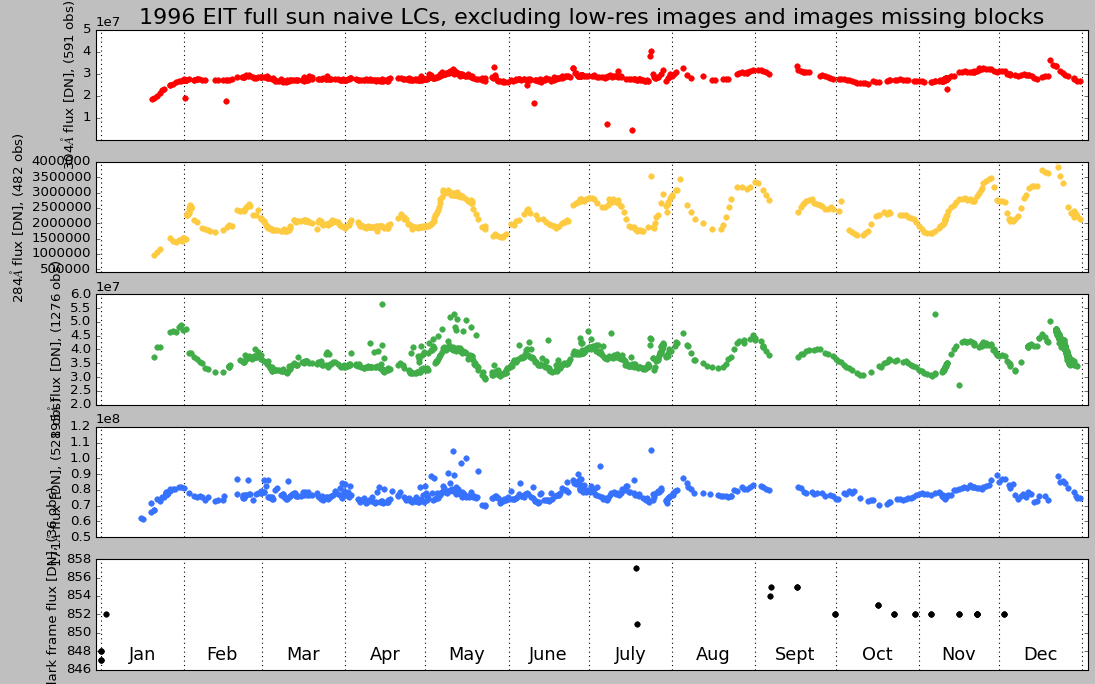

In [90]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    obsTimes_171 = []
    obsTimes_195 = []
    obsTimes_284 = []
    obsTimes_304 = []
    obsTimes_dark = []

    fluxes_171 = []
    fluxes_195 = []
    fluxes_284 = []
    fluxes_304 = []
    fluxes_dark = []
    medianfluxes_dark = []


    nPixs_to_cut = []
    sci_objs = []
    dates = []
    fpaths = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                
                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                fpaths.append(f.path)

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                #This is an extremely naive method of extracting the LC--just sum up all the flux in the image
                #and normalize by exposure time and solar distance
                    
                #pixel counts have units of DN/s already so they've already been normalized by exposure time
                #pixel count * exp time has units of DN

                #to weight by distance, want to trim the edges of all the images so that they have the same field of
                #view as the one taken closest to the Sun (where the Sun has angular radius maxSolarRad = 986.010427668arcsec)

                #exclude pathological case where solar distance is 0
                if header['DSUN_OBS'] < 1.e11:
                    continue
                    
                #physical scale of each pixel in nearest 1996 image is:
                minPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * minSolarDistance
                minPhysImageDiameter = minPhysPixelScale*1024

                #physical scale of each pixel in this image is:
                thisPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * header['DSUN_OBS']
                thisImageDiameter = thisPhysPixelScale * 1024

                #Tomorrow: interpolate this!! Jump in integer number of pixels cut causes discontinuities
                nPix_to_cut = (thisImageDiameter - minPhysImageDiameter)/thisPhysPixelScale
                nPix_to_cut = int(np.round(nPix_to_cut/2.,0))

                nPixs_to_cut.append(nPix_to_cut)
                if "full_sun" in sci_obj_: 
                    hist = str(header['HISTORY'])

                    # catch the one image with sci_obj_ = 'full_sun_304' which
                    # doesn't have a wavelength keyword (it seems to be a mislabeled dark image?) 
                    if "Data not calibrated" in hist:
                        continue
                        
                    wavelength = header['WAVELNTH']
                   
                    #exclude lower-resolution or partial images and images with missing data blocks
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0:
                        if wavelength == 171:
                            obsTimes_171.append(header['DATE-BEG'])
                            if nPix_to_cut > 0:
                                fluxes_171.append(np.sum(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
                            else:
                                fluxes_171.append(np.sum(data))
                            
                        if wavelength == 195:
                            obsTimes_195.append(header['DATE-BEG'])
                            if nPix_to_cut > 0:
                                fluxes_195.append(np.sum(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
                            else:
                                fluxes_195.append(np.sum(data))
                            
                        if wavelength == 284:
                            obsTimes_284.append(header['DATE-BEG'])
                            if nPix_to_cut > 0:
                                fluxes_284.append(np.sum(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
                            else:
                                fluxes_284.append(np.sum(data))
                            
                        if wavelength == 304:
                            obsTimes_304.append(header['DATE-BEG'])
                            if nPix_to_cut > 0:
                                fluxes_304.append(np.sum(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
                            else:
                                fluxes_304.append(np.sum(data))
    
                elif "dark_image" in sci_obj_:
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        obsTimes_dark.append(header['DATE-BEG']) 
                        fluxes_dark.append(np.sum(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
                        medianfluxes_dark.append(np.median(data[nPix_to_cut:-nPix_to_cut, nPix_to_cut:-nPix_to_cut]))
    
    tDark = astropy.time.Time(obsTimes_dark, format='isot', scale='utc').jd
    t171 = astropy.time.Time(obsTimes_171, format='isot', scale='utc').jd
    t195 = astropy.time.Time(obsTimes_195, format='isot', scale='utc').jd
    t284 = astropy.time.Time(obsTimes_284, format='isot', scale='utc').jd
    t304 = astropy.time.Time(obsTimes_304, format='isot', scale='utc').jd

    f171 = np.array(fluxes_171)
    f195 = np.array(fluxes_195)
    f284 = np.array(fluxes_284)
    f304 = np.array(fluxes_304)
    fDark = np.array(fluxes_dark)
    mfDark = np.array(medianfluxes_dark)
    
    fig, axes = plt.subplots(5,1,figsize=(16,10))

    runningdaycount = 0
    for i, d in enumerate(dayspermonth):
        for ax in axes:
            ax.axvline(runningdaycount,color='k',ls=':')    
        axes[4].text(runningdaycount + d/2, 847, months[i],horizontalalignment='center',fontsize=16)
        runningdaycount = runningdaycount+d
        # leap years
        if year%4 == 0 and i==1:
            runningdaycount = runningdaycount + 1
    
    axes[4].plot(tDark-jan1_thisyear, mfDark, ls='None',marker='.',ms=10,c='k')
    axes[3].plot(t171-jan1_thisyear, f171, ls='None',   marker='.',ms=10,c='#3772ff')
    axes[2].plot(t195-jan1_thisyear, f195, ls='None', marker='.',ms=10,c='#41ad49')
    axes[1].plot(t284-jan1_thisyear, f284, ls='None', marker='.',ms=10,c='#fdca40')
    axes[0].plot(t304-jan1_thisyear, f304, ls='None', marker='.',ms=10,c='r')
    #ax.set_xlabel('time', fontsize=16) #("BJD-2450083.5 [days since 01/01/{0} 00:00 UTC]".format(year),fontsize=16)

    axes[4].set_ylabel("Median dark frame flux [DN], ({0} obs)".format(len(tDark)))
    axes[3].set_ylabel(r"171$\AA$ flux [DN], ({0} obs)".format(len(t171)))
    axes[2].set_ylabel(r"195$\AA$ flux [DN], ({0} obs)".format(len(t195)))
    axes[1].set_ylabel(r"284$\AA$ flux [DN], ({0} obs)".format(len(t284)))
    axes[0].set_ylabel(r"304$\AA$ flux [DN], ({0} obs)".format(len(t304)))

    for ax in axes[1:]:
        ax.ticklabel_format(style='sci')

    for ax in axes:
        ax.set_xticks([])
        ax.set_xlim(-2,runningdaycount+2)

    
    axes[3].set_ylim(0.5e8,1.2e8)
    axes[2].set_ylim(0.2e8,0.6e8)
    axes[1].set_ylim(0.4e6,4.e6)
    axes[0].set_ylim(0.1,0.5e8)
    
    axes[0].set_title(r'{0} EIT full sun naive LCs, excluding low-res images and images missing blocks'.format(year),fontsize=20)
    #plt.show()
    plt.savefig("./EITnaiveLCs_{0}.pdf".format(year), bbox_inches="tight")
    

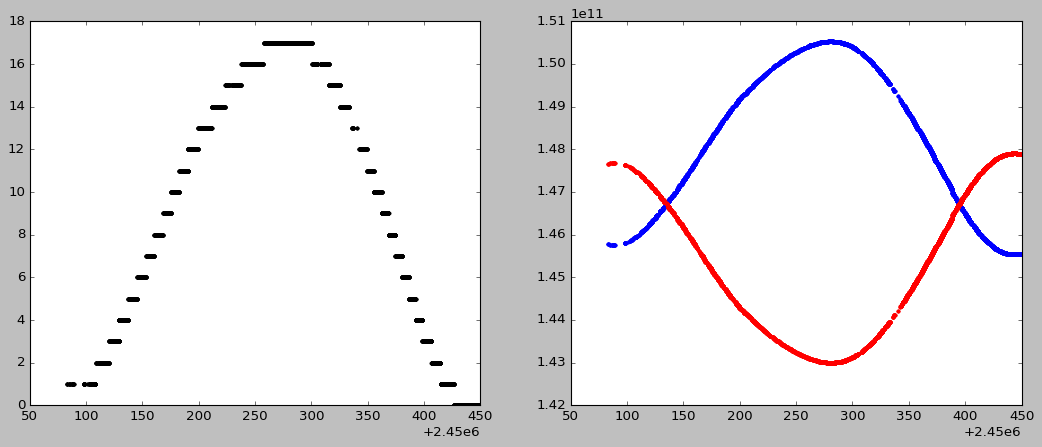

In [75]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].plot(t[solarDistances>1.e11],np.array(nPixs_to_cut),'k.')
axes[1].plot(t[solarDistances>1.e11], solarDistances[solarDistances>1.e11],'b.')
axes[1].plot(t[solarDistances>1.e11], solarRads[solarDistances>1.e11]*1.5e8,'r.')
plt.show()

528
526


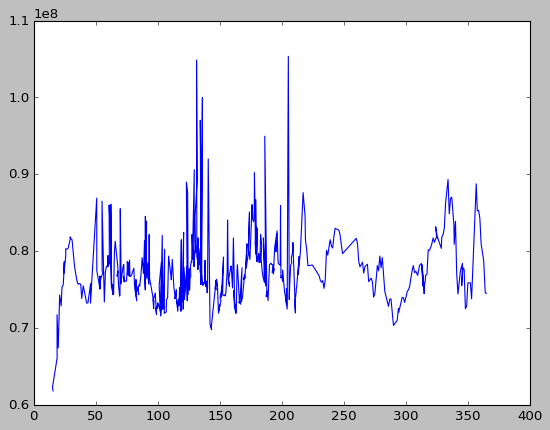

In [88]:
plt.plot(t171-jan1_thisyear, f171)
print(len(f171))
print(len(f171[1:-1]))